**All imports**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import random

**Helper functions**

In [2]:
def correlation_plot(df, targetVariable, featureVariable):
    fig1, ax1 = plt.subplots()
    ax1.scatter(df[targetVariable], df[featureVariable], s=3)

    ax1.set_xlabel(targetVariable)
    ax1.set_ylabel(featureVariable)

    # r-waarde en p-waarde
    correlation = df[[targetVariable, featureVariable]].corr().iloc[0, 1]

    # toevoegen aan de titel
    ax1.set_title(f"{targetVariable} vs {featureVariable} (r = {correlation:.2f})")

**Load the dataset**

In [45]:
dfr = pd.read_csv('data/movie-1.csv')

**Copy of the dataset**

Making a copy of the data to work with so we will not alter the actual dataset given.

In [5]:
df = dfr.copy()

**Taking a look at the data we're given**

In [6]:
df.head(5)

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [7]:
df.describe(include="all")

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
count,5024,4939,4993.000000,5028.000000,4939.000000,5020.000000,5030,5036.000000,4.159000e+03,5043,...,5022.000000,5029,5038,4740,4.551000e+03,4935.000000,5030.000000,5043.000000,4714.000000,5043.000000
unique,2,2398,NaN,NaN,NaN,NaN,3032,NaN,NaN,914,...,NaN,46,65,18,NaN,NaN,NaN,NaN,NaN,NaN
top,Color,Steven Spielberg,NaN,NaN,NaN,NaN,Morgan Freeman,NaN,NaN,Drama,...,NaN,English,USA,R,NaN,NaN,NaN,NaN,NaN,NaN
freq,4815,26,NaN,NaN,NaN,NaN,20,NaN,NaN,236,...,NaN,4704,3807,2118,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,140.194272,107.201074,686.509212,645.009761,NaN,6560.047061,4.846841e+07,NaN,...,272.770808,NaN,NaN,NaN,3.975262e+07,2002.470517,1651.754473,6.442138,2.220403,7525.964505
std,NaN,NaN,121.601675,25.197441,2813.328607,1665.041728,NaN,15020.759120,6.845299e+07,NaN,...,377.982886,NaN,NaN,NaN,2.061149e+08,12.474599,4042.438863,1.125116,1.385113,19320.445110
min,NaN,NaN,1.000000,7.000000,0.000000,0.000000,NaN,0.000000,1.620000e+02,NaN,...,1.000000,NaN,NaN,NaN,2.180000e+02,1916.000000,0.000000,1.600000,1.180000,0.000000
25%,NaN,NaN,50.000000,93.000000,7.000000,133.000000,NaN,614.000000,5.340988e+06,NaN,...,65.000000,NaN,NaN,NaN,6.000000e+06,1999.000000,281.000000,5.800000,1.850000,0.000000
50%,NaN,NaN,110.000000,103.000000,49.000000,371.500000,NaN,988.000000,2.551750e+07,NaN,...,156.000000,NaN,NaN,NaN,2.000000e+07,2005.000000,595.000000,6.600000,2.350000,166.000000
75%,NaN,NaN,195.000000,118.000000,194.500000,636.000000,NaN,11000.000000,6.230944e+07,NaN,...,326.000000,NaN,NaN,NaN,4.500000e+07,2011.000000,918.000000,7.200000,2.350000,3000.000000


**Get the column names to see with what kind of variables we're working with**

In [8]:
for col in df.columns:
    print(f"column: {col}, dtype: {df[col].dtype}")

column: color, dtype: object
column: director_name, dtype: object
column: num_critic_for_reviews, dtype: float64
column: duration, dtype: float64
column: director_facebook_likes, dtype: float64
column: actor_3_facebook_likes, dtype: float64
column: actor_2_name, dtype: object
column: actor_1_facebook_likes, dtype: float64
column: gross, dtype: float64
column: genres, dtype: object
column: actor_1_name, dtype: object
column: movie_title, dtype: object
column: num_voted_users, dtype: int64
column: cast_total_facebook_likes, dtype: int64
column: actor_3_name, dtype: object
column: facenumber_in_poster, dtype: float64
column: plot_keywords, dtype: object
column: movie_imdb_link, dtype: object
column: num_user_for_reviews, dtype: float64
column: language, dtype: object
column: country, dtype: object
column: content_rating, dtype: object
column: budget, dtype: float64
column: title_year, dtype: float64
column: actor_2_facebook_likes, dtype: float64
column: imdb_score, dtype: float64
column: 

**What kind of features are present**

Numerical Features:

Categorical Features:

Alphanumeric Features:

**Target and Feature variables**

In [9]:
featureVariables = ['director_name', 'director_facebook_likes',
                    'actor_1_name', 'actor_1_facebook_likes', 
                    'actor_2_name', 'actor_2_facebook_likes', 
                    'actor_3_name', 'actor_3_facebook_likes', 
                    'cast_total_facebook_likes',
                    'movie_facebook_likes',
                    'imdb_score']

targetVariable = ['gross']

**Make another DF with only the columns we're interested in.**

In [10]:
print(df.shape) #check impact
df = df[featureVariables + targetVariable]
print(df.shape) #check impact

(5043, 28)
(5043, 12)


In [11]:
df.head(1)

,director_name,director_facebook_likes,actor_1_name,actor_1_facebook_likes,actor_2_name,actor_2_facebook_likes,actor_3_name,actor_3_facebook_likes,cast_total_facebook_likes,movie_facebook_likes,imdb_score,gross
0,James Cameron,0.0,CCH Pounder,1000.0,Joel David Moore,936.0,Wes Studi,855.0,4834,33000,7.9,760505847.0


**Check NaN values**

Drop all the NaN values in all the feature and target variables. (for now) Later on we will do more research on how to properly handle these.

In [12]:
df.isna().sum()

director_name                104
director_facebook_likes      104
actor_1_name                   7
actor_1_facebook_likes         7
actor_2_name                  13
actor_2_facebook_likes        13
actor_3_name                  23
actor_3_facebook_likes        23
cast_total_facebook_likes      0
movie_facebook_likes           0
imdb_score                     0
gross                        884
dtype: int64

In [13]:
print(df.shape) #check impact
df = df.dropna()
print(df.shape) #check impact

(5043, 12)
(4143, 12)


In [14]:
df.head(1)

,director_name,director_facebook_likes,actor_1_name,actor_1_facebook_likes,actor_2_name,actor_2_facebook_likes,actor_3_name,actor_3_facebook_likes,cast_total_facebook_likes,movie_facebook_likes,imdb_score,gross
0,James Cameron,0.0,CCH Pounder,1000.0,Joel David Moore,936.0,Wes Studi,855.0,4834,33000,7.9,760505847.0


In [15]:
print(df.shape) #check impact

(4143, 12)


**Calculate the numeric variables against the target variable so we can look which features are (somewhat) important to the target variable**

In [16]:
correlation = df[['gross',
                'director_facebook_likes', 
                'actor_1_facebook_likes', 
                'actor_2_facebook_likes', 
                'actor_3_facebook_likes', 
                'cast_total_facebook_likes', 
                'movie_facebook_likes', 
                'imdb_score']
                ].corr()['gross'].sort_values(ascending=False)

print(correlation)

gross                        1.000000
movie_facebook_likes         0.377715
actor_3_facebook_likes       0.307898
actor_2_facebook_likes       0.262397
cast_total_facebook_likes    0.246547
imdb_score                   0.200515
actor_1_facebook_likes       0.153992
director_facebook_likes      0.144661
Name: gross, dtype: float64


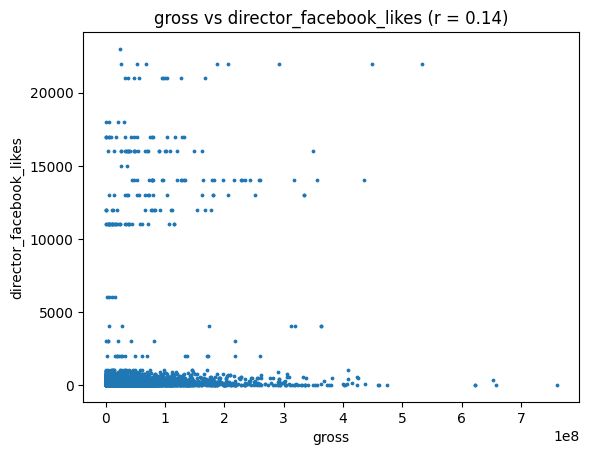

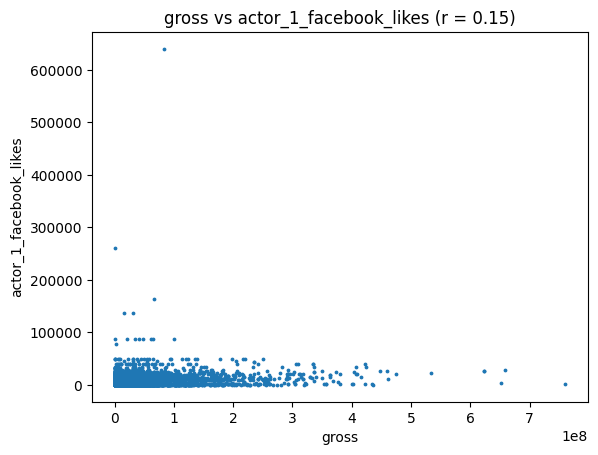

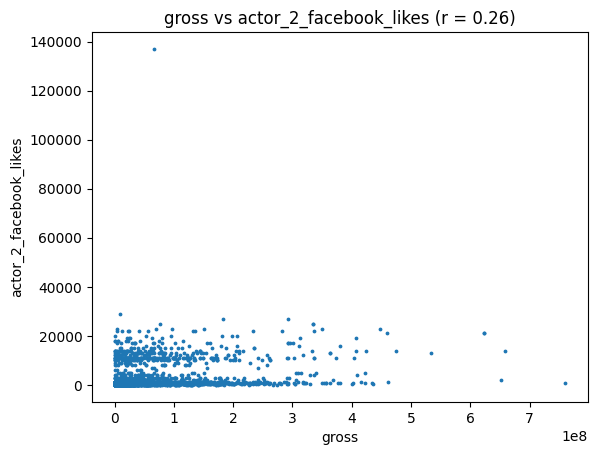

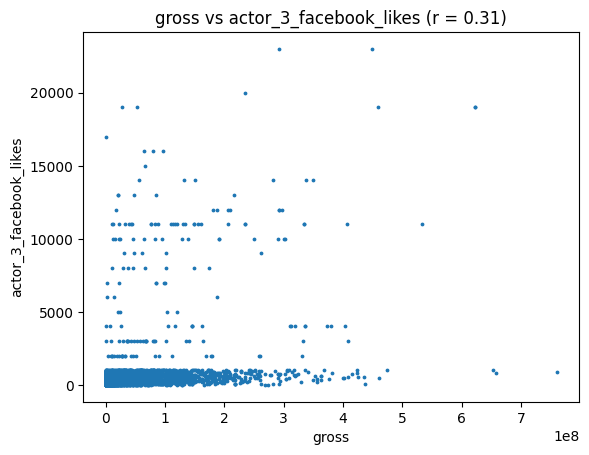

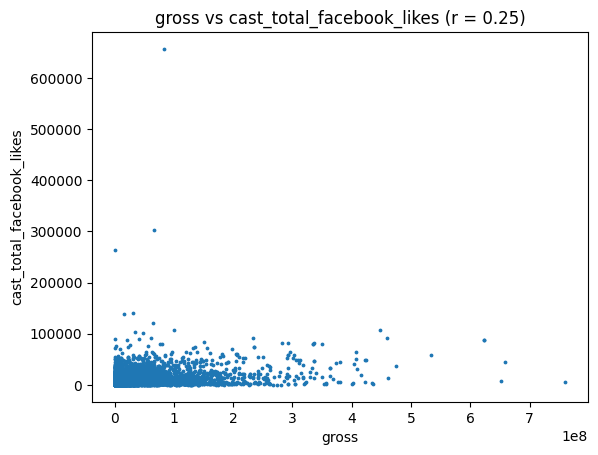

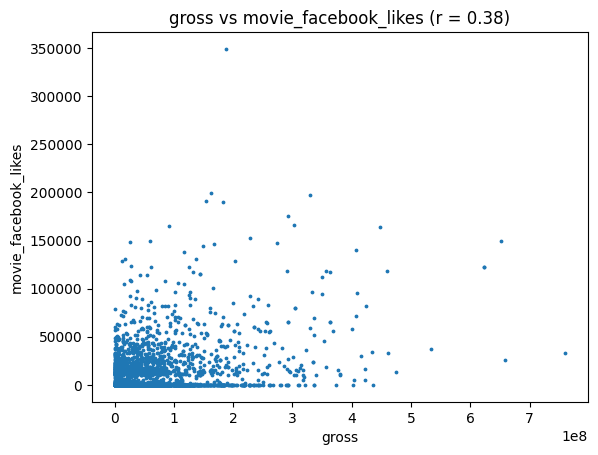

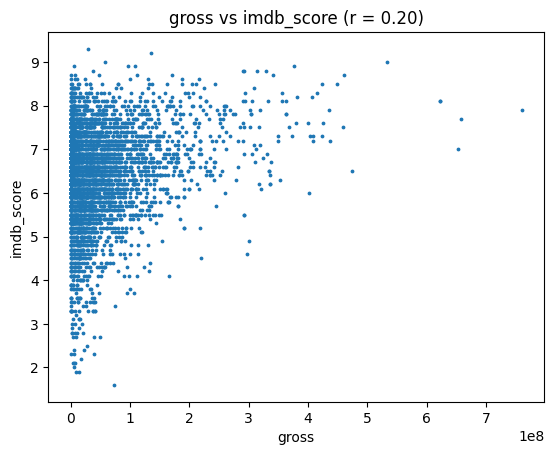

In [17]:
correlation_plot(df, 'gross', 'director_facebook_likes')
correlation_plot(df, 'gross', 'actor_1_facebook_likes')
correlation_plot(df, 'gross', 'actor_2_facebook_likes')
correlation_plot(df, 'gross', 'actor_3_facebook_likes')
correlation_plot(df, 'gross', 'cast_total_facebook_likes')
correlation_plot(df, 'gross', 'movie_facebook_likes')
correlation_plot(df, 'gross', 'imdb_score')

The relationship between IMDb scores and other continuous variables.
With scatter plot.

In [46]:
correlation_imdb = df[['imdb_score',
                       'gross', 
                       'director_facebook_likes', 
                       'actor_1_facebook_likes', 
                       'actor_2_facebook_likes', 
                       'actor_3_facebook_likes', 
                       'cast_total_facebook_likes', 
                       'movie_facebook_likes']
                      ].corr()['imdb_score'].sort_values(ascending=False)

print(correlation_imdb)

imdb_score                   1.000000
movie_facebook_likes         0.271406
gross                        0.200515
director_facebook_likes      0.186026
cast_total_facebook_likes    0.100792
actor_2_facebook_likes       0.096807
actor_1_facebook_likes       0.089703
actor_3_facebook_likes       0.059694
Name: imdb_score, dtype: float64


In [47]:
def scatter(variable, x_label):
    plt.scatter(df[variable], df['imdb_score'])
    plt.title(f'IMDb Score vs. {x_label}')
    plt.xlabel(x_label)
    plt.ylabel('IMDb Score')
    plt.show()


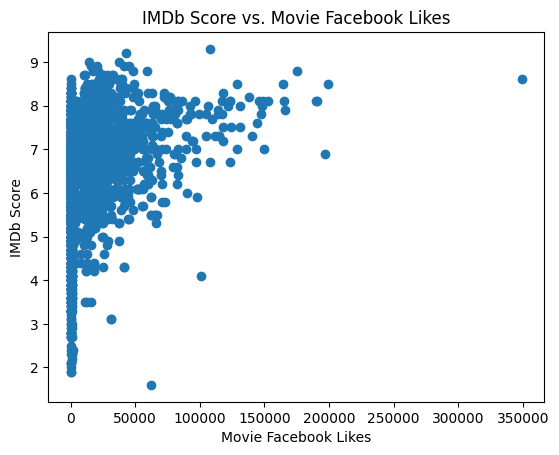

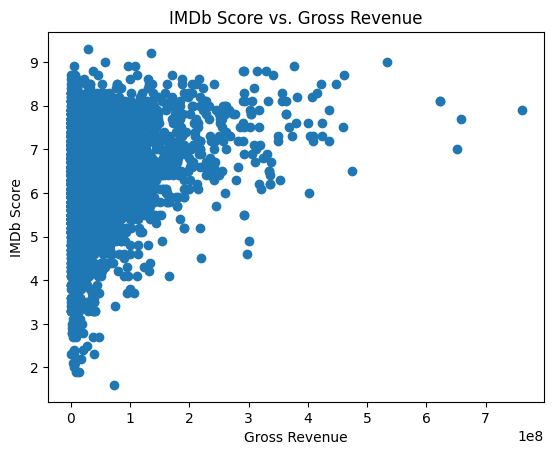

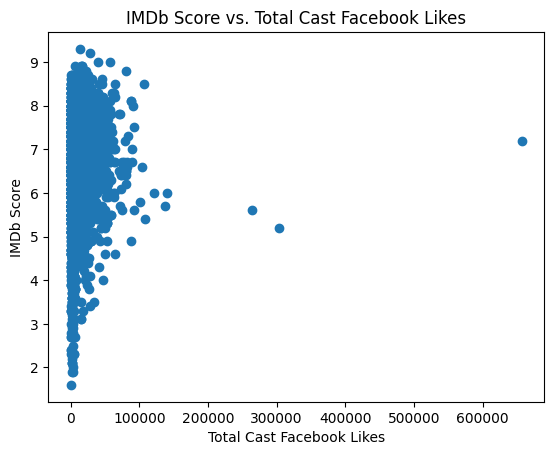

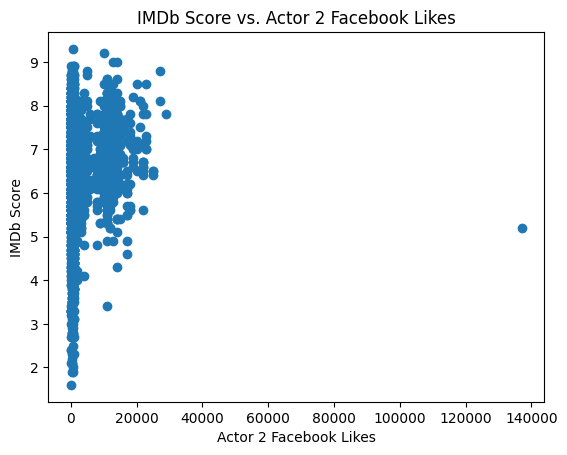

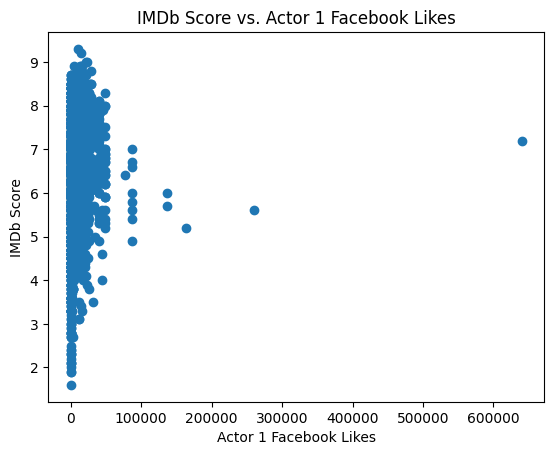

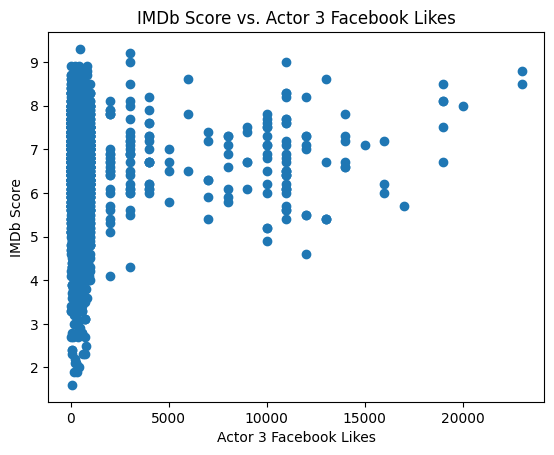

In [48]:
scatter('movie_facebook_likes', 'Movie Facebook Likes')
scatter('gross', 'Gross Revenue')
scatter('cast_total_facebook_likes', 'Total Cast Facebook Likes')
scatter('actor_2_facebook_likes', 'Actor 2 Facebook Likes')
scatter('actor_1_facebook_likes', 'Actor 1 Facebook Likes')
scatter('actor_3_facebook_likes', 'Actor 3 Facebook Likes')

**Assign dummy values to all the names. This is needed to calculate our model.**

In [18]:
#We selecteren de kolommen die wel al uit integers bestaan
X_numeric = df[['director_facebook_likes', 
                'actor_1_facebook_likes', 
                'actor_2_facebook_likes', 
                'actor_3_facebook_likes', 
                'cast_total_facebook_likes', 'movie_facebook_likes', 'imdb_score'
                ]]
#Vervolgens zetten we de andere kolommen om naar integers
X_dummies = pd.get_dummies(df[['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name']], dtype = int)
#We plakken de twee dataframes weer aan elkaar

X = pd.concat([X_numeric, X_dummies], axis = 1)
y = df[['gross']]


X.head(1)

,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,cast_total_facebook_likes,movie_facebook_likes,imdb_score,director_name_Aaron Schneider,director_name_Aaron Seltzer,director_name_Abel Ferrara,...,actor_3_name_Zhengyong Zhang,actor_3_name_Zinedine Soualem,actor_3_name_Zoe Kazan,actor_3_name_Zoe Levin,actor_3_name_Zooey Deschanel,actor_3_name_Zoë Bell,actor_3_name_Zoë Kravitz,actor_3_name_Zoë Poledouris,actor_3_name_Émilie Dequenne,actor_3_name_Óscar Jaenada
0,0.0,1000.0,936.0,855.0,4834,33000,7.9,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
print(X.shape) #check impact

(4143, 8788)
